In [225]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display

from IPython.display import Audio
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from pydub import AudioSegment
from scipy.io.wavfile import write

In [226]:
DATA_PATH = 'data/google'

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [228]:
audio_array,sr = librosa.load("data/gravacao_audio.wav")
audio_array.shape

(22050,)

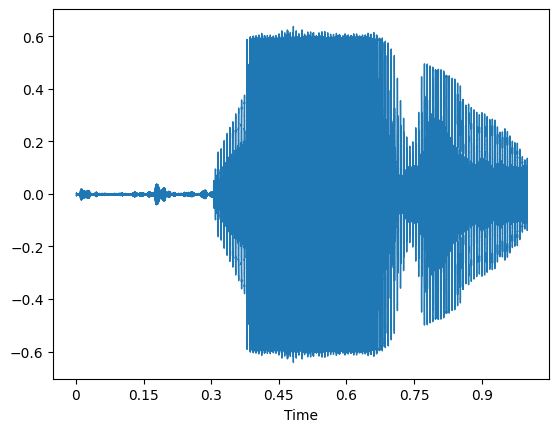

In [229]:
librosa.display.waveshow(audio_array, sr=sr)

In [230]:
x = 'data/gravacao_audio.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
display.display(display.Audio(waveform, rate=16000))

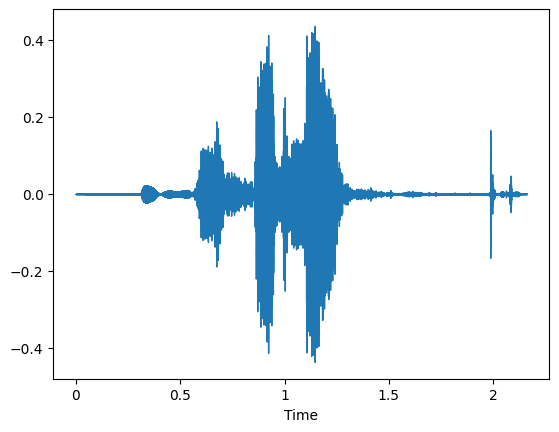

In [231]:
audio_2,sr = librosa.load("data/example.mp3")
librosa.display.waveshow(audio_2, sr=sr)

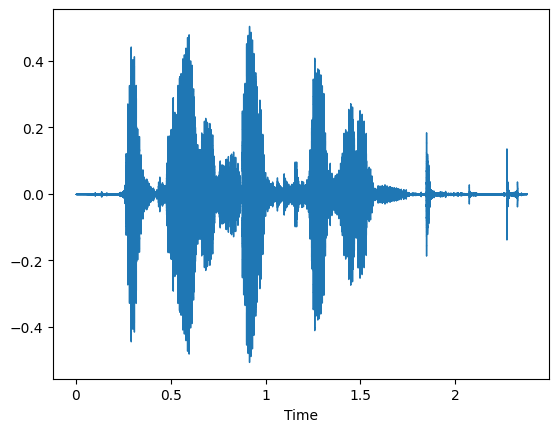

In [232]:
audio_3,sr = librosa.load("data/sentence.mp3")
librosa.display.waveshow(audio_3, sr=sr)

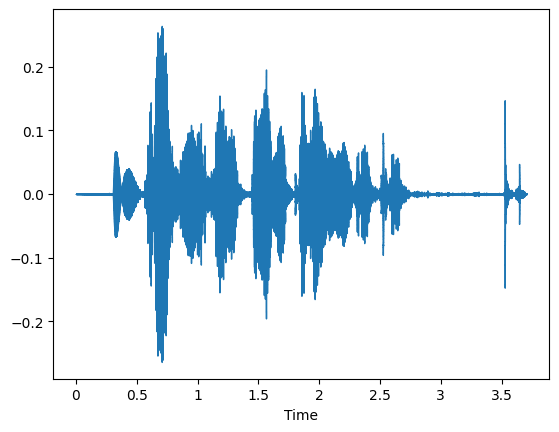

In [233]:
audio_3,sr = librosa.load("G:\project\data\pt2\clips\common_voice_pt_38031045.mp3")
librosa.display.waveshow(audio_3, sr=sr)

# Starting

In [234]:
data_dir = pathlib.Path(DATA_PATH)
# Extraindo do diretório data o nome dos arquivos que significam as palavras disponíveis
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != '.txt') & (commands != 'testing_list.txt') & (commands != 'validation_list.txt')]
print('Commands:', commands)

Commands: ['background' 'backward' 'eden' 'LICENSE' 'marvin' 'off' 'on'
 '_background_noise_']


In [235]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 12192 files belonging to 7 classes.
Using 9754 files for training.
Using 2438 files for validation.

label names: ['_background_noise_' 'background' 'backward' 'eden' 'marvin' 'off' 'on']


In [236]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [237]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [238]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [239]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [240]:
label_names[[0,1,2,3,4,5,6]]

array(['_background_noise_', 'background', 'backward', 'eden', 'marvin',
       'off', 'on'], dtype='<U18')

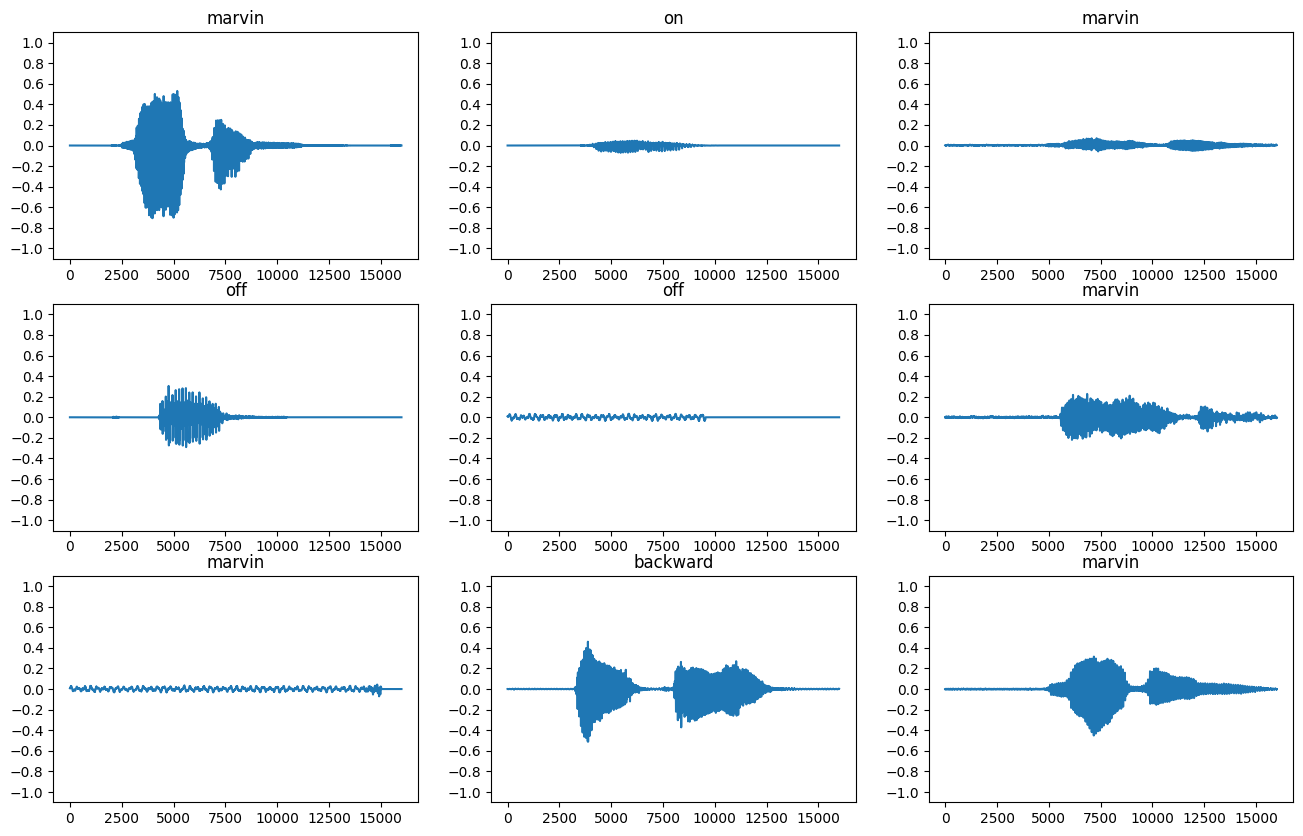

In [241]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [242]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [243]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: marvin
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: on
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: marvin
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [244]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

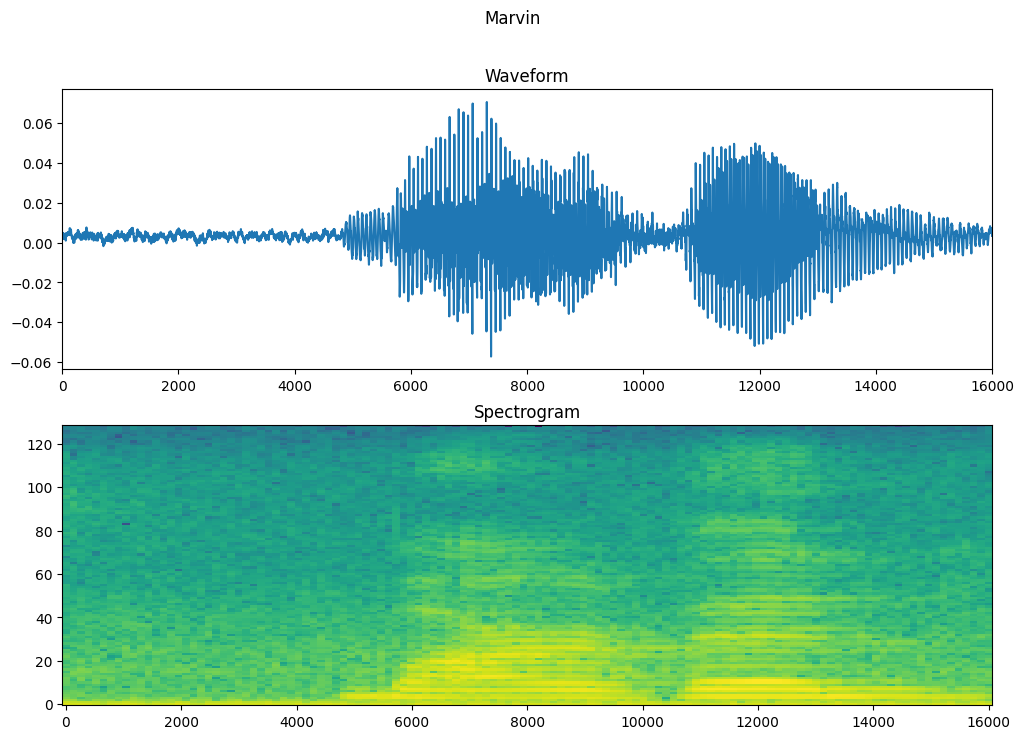

In [245]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [246]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [247]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [248]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

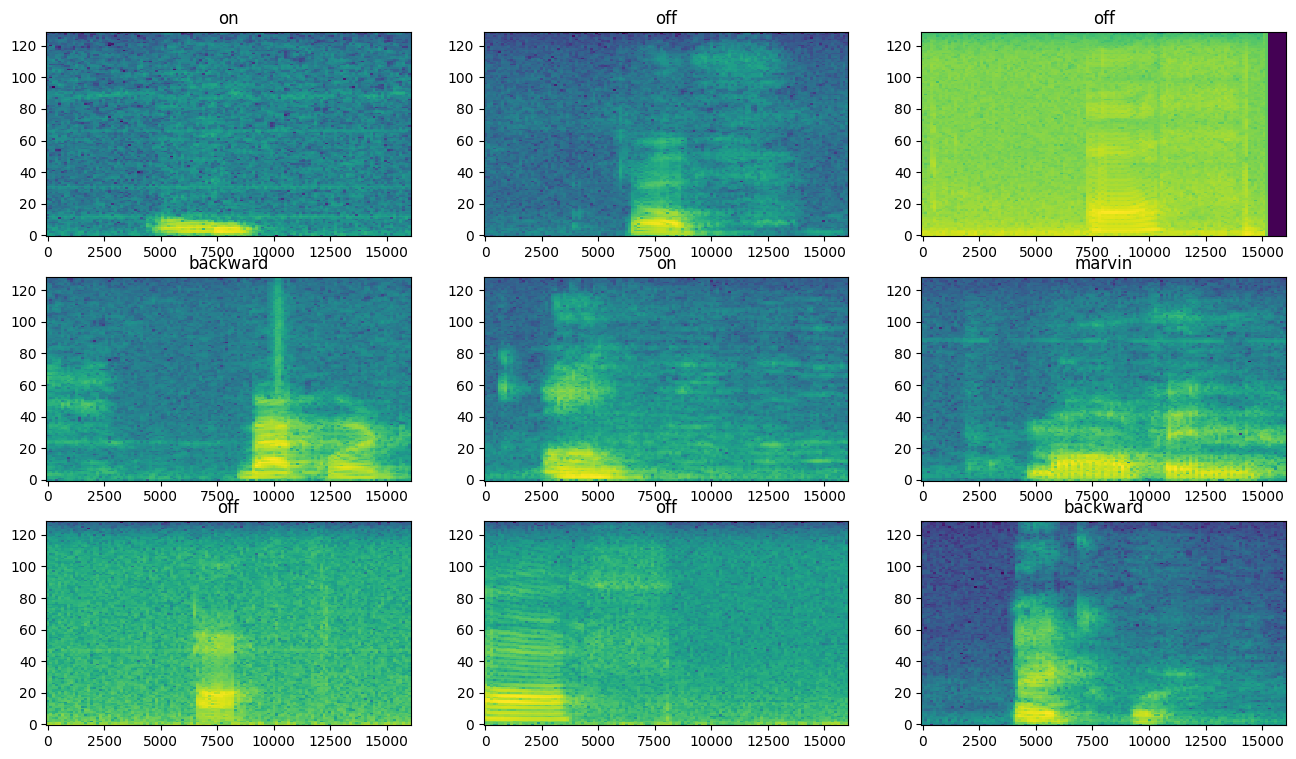

In [249]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [250]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [251]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_5 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)      

In [252]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [253]:
EPOCHS = 9
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/9


153/153 [==============================] - 11s 69ms/step - loss: 1.0903 - accuracy: 0.5840 - val_loss: 0.6829 - val_accuracy: 0.7590
Epoch 2/9
153/153 [==============================] - 10s 65ms/step - loss: 0.6425 - accuracy: 0.7712 - val_loss: 0.4517 - val_accuracy: 0.8676
Epoch 3/9
153/153 [==============================] - 10s 65ms/step - loss: 0.4768 - accuracy: 0.8370 - val_loss: 0.3458 - val_accuracy: 0.8972
Epoch 4/9
153/153 [==============================] - 10s 64ms/step - loss: 0.3914 - accuracy: 0.8686 - val_loss: 0.2772 - val_accuracy: 0.9087
Epoch 5/9
153/153 [==============================] - 10s 64ms/step - loss: 0.3261 - accuracy: 0.8898 - val_loss: 0.2656 - val_accuracy: 0.9054
Epoch 6/9
153/153 [==============================] - 10s 64ms/step - loss: 0.2750 - accuracy: 0.9055 - val_loss: 0.2391 - val_accuracy: 0.9169
Epoch 7/9
153/153 [==============================] - 10s 63ms/step - loss: 0.2575 - accuracy: 0.9131 - val_loss: 0.2416 - val_accuracy: 0.9153
Epoch 8/9

Text(0, 0.5, 'Accuracy [%]')

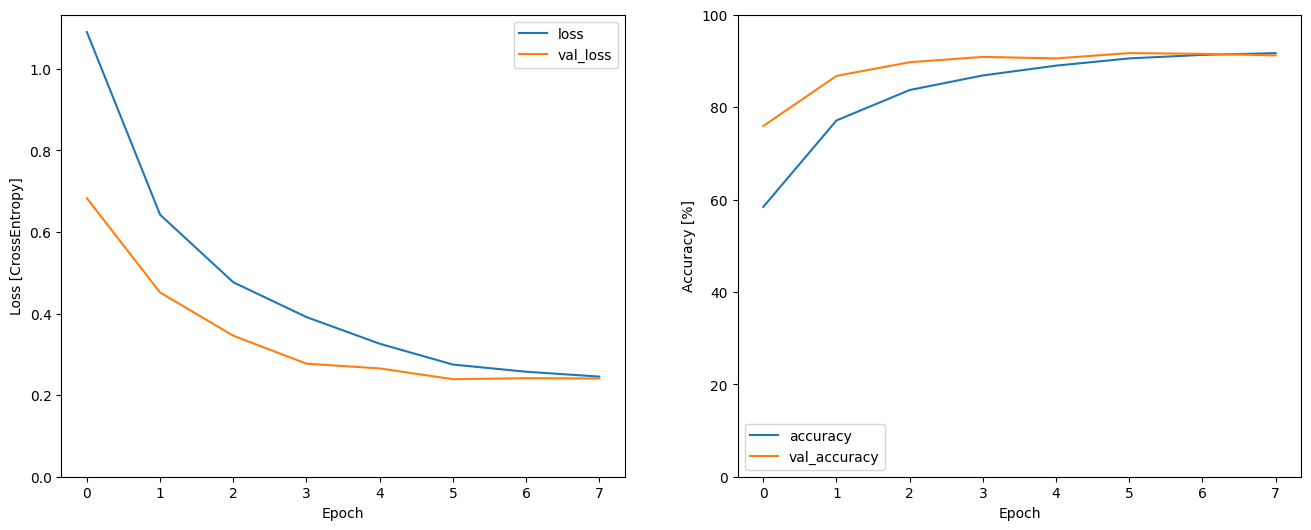

In [254]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [255]:
model.evaluate(test_spectrogram_ds, return_dict=True)

20/20 [==============================] - 1s 22ms/step - loss: 0.2755 - accuracy: 0.9157


{'loss': 0.27554696798324585, 'accuracy': 0.9157119393348694}

In [256]:
y_pred = model.predict(test_spectrogram_ds)

20/20 [==============================] - 0s 12ms/step


In [257]:
y_pred = tf.argmax(y_pred, axis=1)

In [258]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

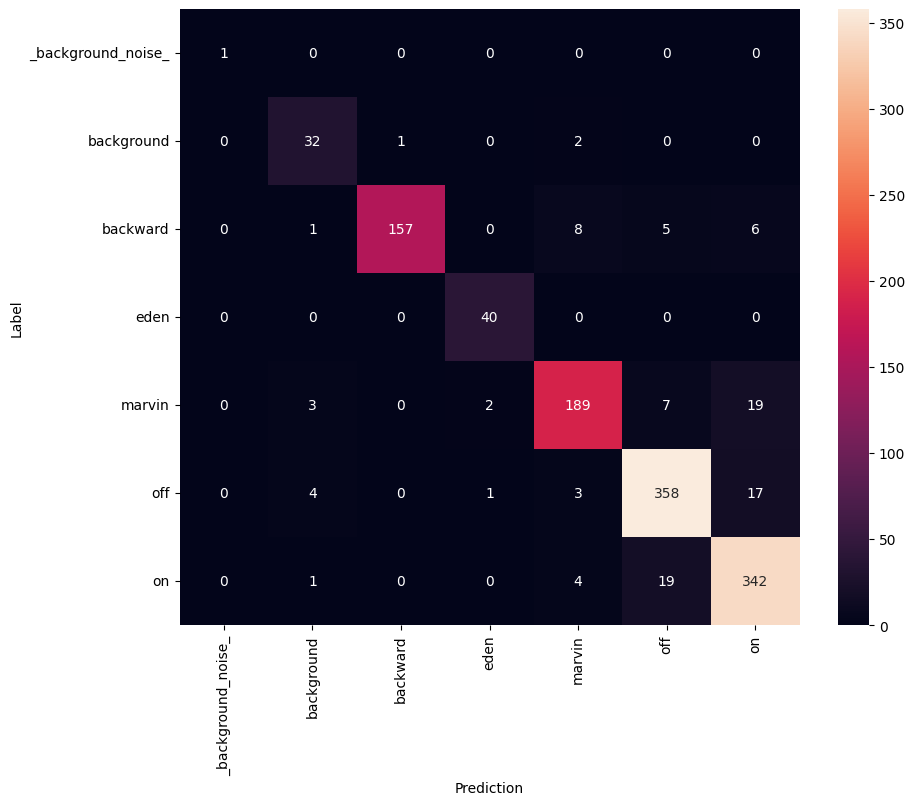

In [259]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

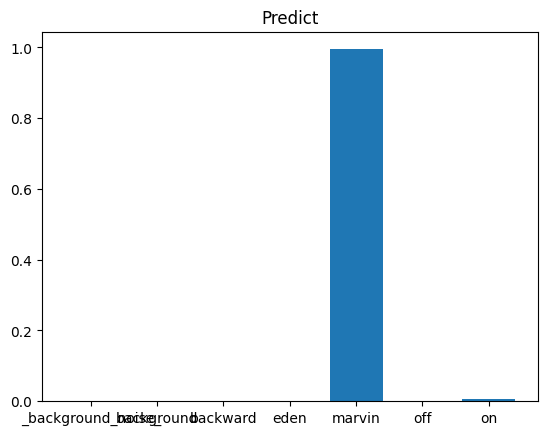

In [260]:
x = 'data/gravacao_audio.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5,6]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

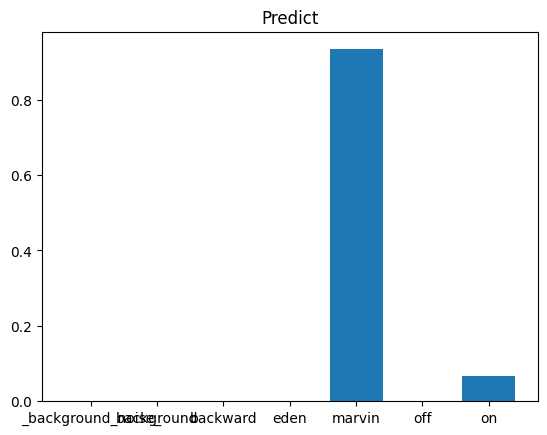

In [261]:
x = 'audios\marvin\Gh6jPiT2mRgravacao_audio.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5,6]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

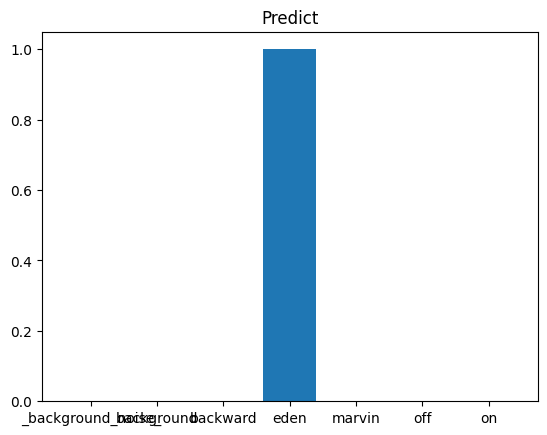

In [262]:
x = 'audios/eden/1bnZDdOdsK.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names[[0,1,2,3,4,5,6]]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predict')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [264]:
model.save("saved")

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets
